<a href="https://colab.research.google.com/github/LouisDo2108/MediaEval2021Fakenews/blob/master/FakeNews_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install requirements and import libraries

In [ ]:
!pip install transformers
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip install -q tf-models-official
!pip install pyyaml h5py
!pip install emoji
!pip install bert-for-tf2
!pip install emot --upgrade
!pip install git+https://github.com/fucaja/ekphrasis.git
!pip install keras-rl2
! pip install git+https://github.com/scikit-optimize/scikit-optimize.git

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 3.3 MB 26.5 MB/s 
     |████████████████████████████████| 59 kB 5.2 MB/s 
     |████████████████████████████████| 895 kB 71.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 23.2 MB 1.2 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 213 kB 64.9 MB/s 
     |████████████████████████████████| 1.1 MB 47.1 MB/s 
     |████████████████████████████████| 99 kB 8.2 MB/s 
     |████████████████████████████████| 47.6 MB 29 kB/s 
     |████████████████████████████████| 352 kB 50.0 MB/s 
     |█████████████████████████████

In [ ]:
import pandas as pd
import numpy as np
import re
from scipy.stats import expon, loguniform
# import feyn
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# import six
# import sys
# sys.modules['sklearn.externals.six'] = six
# import mlrose

from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score, make_scorer, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
import sklearn.linear_model as sklm
import sklearn.neural_network as skn
import sklearn.neighbors as skneighbor
import sklearn.ensemble as ske
import sklearn.svm as sksvm
import sklearn.multiclass as skm
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
import itertools
# from mlxtend.classifier import StackingCVClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
import gc
import os.path

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

from official.nlp import optimization
from bert import bert_tokenization
from transformers import BertModel, BertTokenizer, BertConfig, TFAutoModelForSequenceClassification, AutoModel, AutoTokenizer

import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from emoji import demojize
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO 
from ekphrasis.classes.segmenter import Segmenter
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
import wordcloud

nltk.download
nltk.download('wordnet')
nltk.download('stopwords')

# from transformers import BertTokenizer, BertConfig, BertModel
# from sys import getsizeof

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Preprocessing

In [ ]:
#@title
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

#@title
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags <hashtag>
    unpack_contractions=True,  # Unpack contractions (can't -> can not) <number>
    spell_correct_elong=True,  # spell correction for elongated words <Repeated>
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [ ]:
import string
class dataset():
    
    def __init__(self, data_path):
        # self.df = pd.read_csv(data_path, encoding='utf-8', sep='\t', names=['index', 'label', 'text'])
        self.df = pd.read_csv(data_path, encoding='utf-8', sep=',', names=['index', 'text'])
        self.data = None
        
    def __len__(self):
        return self.df.size
    
    def __str__(self):
        return print(self.df)

    def __getitem__(self, indices):
        return str(self.df.text[indices])

    def extract_metadata(self):
      
      # word_count
      self.df['word_count'] = self.df['text'].apply(lambda x: len(str(x).split()))

      # unique_word_count
      self.df['unique_word_count'] = self.df['text'].apply(lambda x: len(set(str(x).split())))

      # stop_word_count
      self.df['stop_word_count'] = self.df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

      # url_count
      self.df['url_count'] = self.df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

      # mean_word_length
      self.df['mean_word_length'] = self.df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

      # char_count
      self.df['char_count'] = self.df['text'].apply(lambda x: len(str(x)))

      # punctuation_count
      self.df['punctuation_count'] = self.df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

      # hashtag_count
      self.df['hashtag_count'] = self.df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

      # mention_count
      self.df['mention_count'] = self.df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

      # extract meta features
      # self.df['hashtag'] = self.df['text'].apply(lambda x: re.findall(r"#(\w+)", x))
      # self.df['mention'] = self.df['text'].apply(lambda x: re.findall(r"@mention'", x))
      return

    def preprocessing(self):

        # Add labels row and drop index column
        self.df.dropna(inplace = True)
        self.df.drop('index', axis=1, inplace=True)
        self.df.text = self.df.text.astype(str)

        # convert categorical labels to numerical labels
        # self.df.label = pd.Categorical(self.df.label)
        # self.df['label'] = self.df.label.cat.codes

        self.df.loc[:, 'text'] =self.df.text.apply(lambda x: x.lower()) #lower case
        self.df.loc[:, 'text'] =self.df.text.str.replace('’', '\'')
        self.df.drop_duplicates(subset=None, keep="first", inplace=True)

        # expand contractions
        def expand_contractions(text):
          text = ' '.join([contractions.get(i, i) for i in text.split()])
          return text
        self.df.loc[:, 'text'] = self.df.text.apply(lambda x: expand_contractions(x))
        self.df.loc[:, 'text'] =self.df.text.str.replace('#', '')
        table = str.maketrans('', '', string.punctuation)
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        self.df.loc[:, 'text'] =self.df.text.apply(lambda x: regex.sub('', x))

        self.df.loc[:, 'text'] =self.df.text.str.replace("\xc2\xa0", '') #remove bad space
        # self.df.loc[:, 'text'] =self.df.text.apply(lambda x:re.sub(r'[^\w\s]',' ',str(x), re.UNICODE)) #remove punctuation

        #  Expand slang, abbr:
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\s4\s', ' for ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r"\s2\s", ' to ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'[a-zA-Z]2[a-zA-Z]', ' to ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sw\/\s', ' with ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sb\/c\s', ' because ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sb4\s', ' before ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\scre8\s', ' create ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sda\s', ' the ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sya\s', ' you ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\slol\s', ' laughing out loud ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'lol\s', ' laughing out loud ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\slol', ' laughing out loud ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sf2f\s', ' face to face ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sfomo\s', ' fear of missing out ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sftw\s', ' for the win ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\slol\s', ' laughing out loud ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\slmao\s', ' laughing my ass out ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sic\s', ' i see ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\skk\s', ' okay ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sprt\s', ' please retweet ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\ssp\s', ' sponsored ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\stbh\s', ' to be honest ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sb\s', ' be ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sr\s', ' are ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sc\s', ' see ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\bu\b', ' you ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\bu\b', ' you ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\by\b', ' why ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\bq\b', ' qanon ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\bq\b', ' qanon ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sppl\s*', ' people ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sbjp\s', ' bharatiya janata party ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sblm\s', ' black lives matter ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\scld\s', ' could ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\schk\s', ' check ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sbtw\s', ' by the way ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\sbrb\s', ' be right back ')
        self.df.loc[:, 'text'] =self.df.text.str.replace(r'\swtv\s', ' whatever ')

        # extract url domain
        def domain_name(url):
          exurl = url.split("//")[-1].split("/")[0].split('?')[0]
          if exurl != None:
            return exurl
          return url

        def replace_url_placeholder(index):
          links = self.df.url[index]

          if(len(links) <= 0):
            return self.df.text[index]
        
          sentence = self.df.text[index]
          for i in range(len(links)):
            sentence = re.sub(r"_url", str(links[i]), str(sentence), count = 1)
          return sentence

        self.df['url'] = self.df['text'].apply(lambda x: re.findall(r"\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b", str(x)))
        self.df['text'] = self.df['text'].apply(lambda x: re.sub(r"\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b", '_url', str(x)))
        self.df['url'] = self.df['url'].apply(lambda x: [domain_name(url) for url in x])
        
        for i in range(len(self.df.text)):
            if len(self.df.url.values[i]) > 0:
                self.df.loc[i, 'text'] = replace_url_placeholder(i)

        # convert emoji and emoticons to text
        def convert_emoticons(text):
          for emot in EMOTICONS_EMO:
            text = text.replace(emot, "_".join(re.split(',| ',EMOTICONS_EMO[emot])))
          return text

        self.df.loc[:, 'text'] =self.df.text.apply(lambda x: demojize(x)) #emoji      
        self.df.loc[:, 'text'] =self.df.text.apply(lambda x: convert_emoticons(x)) #emoticon


        # remove videos and links
        self.df.loc[:, 'text'] = self.df.text.str.replace('{link}', '')
        self.df.loc[:, 'text'] = self.df.text.str.replace("\[video\]", '')
        
        self.df.loc[:, 'text'] =self.df.text.str.replace('&[a-z]+;', '')
        self.df.loc[:, 'text'] =self.df.text.str.replace(' {2,}', ' ')
        self.df.loc[:, 'text'] =self.df.text.str.replace('^.^', 'smile')
          
        self.df.loc[:, 'text'] = self.df.text.apply(lambda x: " ".join(text_processor.pre_process_doc(x)))
        
        # self.data = self.df[['label', 'text']]
        self.data = self.df['text']
        self.data.drop_duplicates(inplace=True)

In [ ]:
# data_path = "/content/drive/MyDrive/FakeNews/Data/new/extended_from_dev3.csv"
# df = dataset(data_path)
# df.preprocessing()
# df.data.to_csv('/content/drive/MyDrive/FakeNews/Data/extended-preprocessed.csv', encoding='utf-8', index=False)
# labelZero = df.loc[df['label'] == 0].sample(frac=1, random_state=42).head(500)
# labelOne = df.loc[df['label'] == 1]
# labelTwo = df.loc[df['label'] == 2]
### uncomment and run this cell if you run for raw data
# data = pd.read_csv("/content/drive/MyDrive/FakeNews/Test/test-task-1.csv", encoding='utf-8',)
data_path = "/content/drive/MyDrive/FakeNews/Test/test-task-1.csv"
df = dataset(data_path)
df.preprocessing()
df.data.to_csv('/content/drive/MyDrive/FakeNews/Data/test-preprocessed.csv', encoding='utf-8', index=False)

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/FakeNews/Data/test-preprocessed.csv")
testt

,text
0,<number> it was not spread by snakes or bats i...
1,trump and cult think fraud billionaires can ru...
2,what if the coronavirus is not a virus but a d...
3,sad but i cannot say i am surprised unfortunat...
4,i have not read koontz in decades but i rememb...
...,...
261,the fact they have all been fully vaccinated a...
262,<number> control small electrical appliances f...
263,yes commissions to prom were given as per cont...
264,who cares a strain of covid has never actually...


# Define tokenizer

In [ ]:
MAX_SEQUENCE_LENGTH = 64

PRETRAINED_MODEL_NAME = "digitalepidemiologylab/covid-twitter-bert-v2"#"digitalepidemiologylab/covid-twitter-bert/2" #'vinai/bertweet-covid19-base-uncased' 

# Number of labels:
number_of_label = 3#train['label'].nunique()

def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    truncation = True,
    return_token_type_ids=True, # not needed for this type of ML task
    padding='max_length', # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

def CreateModel(model_class, tokenizer_class, pretrained_weights):
  model_class, tokenizer_class, pretrained_weights = (model_class, tokenizer_class, pretrained_weights)

  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  return tokenizer

tokenizer = CreateModel(AutoModel, AutoTokenizer, PRETRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Extract features for sklearn models

In [ ]:
from transformers import AutoModel

data_path = "/content/drive/MyDrive/FakeNews/Test/test-preprocessed.csv"
data = pd.read_csv(data_path)

def CreateModel(model_class, tokenizer_class, pretrained_weights):
  model_class, tokenizer_class, pretrained_weights = (model_class, tokenizer_class, pretrained_weights)

  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights, output_hidden_states=True)
  return tokenizer, model

tokenizer, model = CreateModel(AutoModel, AutoTokenizer, PRETRAINED_MODEL_NAME)

def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    truncation = True,
    return_token_type_ids=True,
    padding='max_length', # add 0 pad tokens to the sequences less than max_length
    return_tensors='pt'
)

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import gc

def save_embedding_mini_batch(data_size, batch_size, model, path, filename, X_train):
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  for batch in range(0, int(data_size / batch_size) + 1):
    torch.cuda.empty_cache()

    # mini_batch_input_ids = X_train['input_ids'][batch*batch_size:]
    # mini_batch_attention_mask = X_train['attention_mask'][batch*batch_size:]
    # mini_batch_token_type_ids = X_train['token_type_ids'][batch*batch_size:]

    print("Batch {}".format(batch))

    if (batch+1)*batch_size > data_size:
      mini_batch_input_ids = X_train['input_ids'][batch*batch_size:]
      mini_batch_attention_mask = X_train['attention_mask'][batch*batch_size:]
      mini_batch_token_type_ids = X_train['token_type_ids'][batch*batch_size:]
    else:
      mini_batch_input_ids = X_train['input_ids'][batch*batch_size:(batch+1)*batch_size]
      mini_batch_attention_mask = X_train['attention_mask'][batch*batch_size:(batch+1)*batch_size]
      mini_batch_token_type_ids = X_train['token_type_ids'][batch*batch_size:(batch+1)*batch_size]

    with torch.no_grad():
      output = model(input_ids=mini_batch_input_ids.to(device), attention_mask=mini_batch_attention_mask.to(device), token_type_ids=mini_batch_token_type_ids.to(device))
    
    print(len(output[2]))
    output = list(output[2])
    filepath = path + filename + str(batch) + ".pt"
    print(filepath)

    torch.save(output, filepath)
    print("saved")

    del output
    gc.collect()
print("Done")

Done


In [ ]:
X_train = batch_encode(list(data.text.values), tokenizer)

In [ ]:
X_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
batch_size = len(data) + 1
data_size = len(data)
path = "/content/drive/MyDrive/FakeNews/Test/"
filename = "embedding"
save_embedding_mini_batch(data_size, batch_size, model, path, filename, X_train)

Batch 0
25
/content/drive/MyDrive/FakeNews/Test/embedding0.pt
saved


In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

# covid-twitter-bert-v2 Embedding

In [ ]:
def CreateModel(model_class, tokenizer_class, pretrained_weights):
  model_class, tokenizer_class, pretrained_weights = (model_class, tokenizer_class, pretrained_weights)

  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights, output_hidden_states = True)
  model.eval()
  return model, tokenizer

def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=64, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    truncation = True,
    return_token_type_ids=False,
    padding='max_length', # add 0 pad tokens to the sequences less than max_length
    return_tensors='pt'
)
    
model, tokenizer = CreateModel(BertModel, BertTokenizer, 'digitalepidemiologylab/covid-twitter-bert-v2')

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/FakeNews/Test/test-preprocessed.csv")
X_train = batch_encode(data.text.values, tokenizer)

In [ ]:
def save_embedding_mini_batch(data_size, batch_size, model, path, filename, X_train):

  for batch in range(0, int(data_size / batch_size) + 1):

    print("Batch {}".format(batch))

    if (batch+1)*batch_size >= data_size:
      mini_batch_input_ids = X_train['input_ids'][batch*batch_size:]
      mini_batch_attention_mask = X_train['attention_mask'][batch*batch_size:]
    else:
      mini_batch_input_ids = X_train['input_ids'][batch*batch_size:(batch+1)*batch_size]
      mini_batch_attention_mask = X_train['attention_mask'][batch*batch_size:(batch+1)*batch_size]
    
    with torch.no_grad():
      output = model(mini_batch_input_ids, attention_mask=mini_batch_attention_mask)
    
    output = list(output[2])
    filepath = path + filename + str(batch) + ".pt"
    print(filepath)

    torch.save(output, filepath)
    print("saved")

    del output
    #del features
    gc.collect()
print("Done")

Done


In [ ]:
batch_size = 100
data_size = len(data)
path = "/content/drive/MyDrive/FakeNews/fakenews_embeddings/"
filename = "test"
save_embedding_mini_batch(data_size, batch_size, model, path, filename, X_train)

/content/drive/MyDrive/FakeNews/fakenews_embeddings/test.pt
saved


# Train on Augmented data in batches

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/FakeNews/Data/dev-1-task-1-preprocessed.csv")

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data[:int(len(data)*0.8)].to_csv("/content/drive/MyDrive/FakeNews/Data/dev-1-task-1-preprocessed-train.csv", index=False)
data[int(len(data)*0.8):].to_csv("/content/drive/MyDrive/FakeNews/Data/dev-1-task-1-preprocessed-test.csv", index=False)

data_train = pd.read_csv("/content/drive/MyDrive/FakeNews/Data/dev-1-task-1-preprocessed-train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/FakeNews/Data/dev-1-task-1-preprocessed-test.csv")

In [ ]:
def load_train_features(features_path, features_filename, data_size):
    print("Loading " + features_filename + " features with size ", str(data_size))
    path = features_path + features_filename + "0.npy"
    print(path)
    features = np.load(path)#Init the nparray
    for batch in range(1, int(data_size / 100) + 1):
        path = features_path + features_filename + str(batch) + ".npy"
        feature = np.load(path)
        features = np.vstack((features, feature))
        print(path)
        print("Batch {} completed!".format(batch))
        del feature
        gc.collect()
    print("Done")
    return features

In [ ]:
def load_test_features():
    hidden_states = torch.load("/content/drive/MyDrive/FakeNews/fakenews_embeddings/test.pt")
    cat_features_test = cat_features(hidden_states)
    mean_features_test = mean_features(hidden_states)
    sentence_features_test = sentence_features(hidden_states)
    sentencecls_features_test = sentenceCLS_features(hidden_states)
    return cat_features_test, mean_features_test, sentence_features_test, sentencecls_features_test

In [ ]:
cat_features_train = load_train_features("/content/drive/MyDrive/FakeNews/Features/cat_features/", "catbatch", len(data_train))
mean_features_train = load_train_features("/content/drive/MyDrive/FakeNews/Features/mean_features/", "meanbatch", len(data_train))
sentence_features_train = load_train_features("/content/drive/MyDrive/FakeNews/Features/sentence_features/", "sentencebatch", len(data_train))
sentencecls_features_train = load_train_features("/content/drive/MyDrive/FakeNews/Features/sentencecls_features/", "sentenceclsbatch", len(data_train))

In [ ]:
cat_features_test, mean_features_test, sentence_features_test, sentencecls_features_test = load_test_features()

Shape is: 100 x 256 x 1024
Shape is: 100 x 256 x 1024
Shape is: 100 x 64 x 1024
Shape is: 100 x 1024
Shape is: 100 x 1024


In [ ]:
print(cat_features_train.shape, getsizeof(cat_features_train))
print(mean_features_train.shape, getsizeof(mean_features_train))
print(sentence_features_train.shape, getsizeof(sentence_features_train))
print(sentencecls_features_train.shape, getsizeof(sentencecls_features_train))
print(cat_features_test.shape, getsizeof(cat_features_test))
print(mean_features_test.shape, getsizeof(mean_features_test))
print(sentence_features_test.shape, getsizeof(sentence_features_test))
print(sentencecls_features_test.shape, getsizeof(sentencecls_features_test))

In [ ]:
train_features = [cat_features_train, mean_features_train, sentence_features_train, sentencecls_features_train]
test_features = [cat_features_test, mean_features_test, sentence_features_test, sentencecls_features_test]
features = list(zip(train_features, test_features))
del train_features
del test_features
gc.collect()

In [ ]:
score = []
mcc = []
models = [#"Perceptron", 
          #"SGDHinge", "SGDLog", "SGDModified_huber", "SGDSquared_hinge", "SGDPerceptron"]
          "LogisticRegression", "SVC", "LinearSVC"]
feature_names = ['Cat', "Mean", "Sentence", "CLS"]
classifiers = [#sklm.Perceptron(n_jobs=-1),
            #   sklm.SGDClassifier(n_jobs=-1, loss='hinge'), 
            #   sklm.SGDClassifier(n_jobs=-1, loss='log'),
            #   sklm.SGDClassifier(n_jobs=-1, loss='modified_huber'),
            #   sklm.SGDClassifier(n_jobs=-1, loss='squared_hinge'), 
            #   sklm.SGDClassifier(n_jobs=-1, loss='perceptron')]
              sklm.LogisticRegression(n_jobs=-1), sksvm.SVC(), sksvm.LinearSVC()]         

In [ ]:
for i, c in enumerate(classifiers):
    print(i, ". Training ", models[i])
    i = 0
    for feature in features:
        clf = c
        print("\tUsing ", feature_names[i], " features")
        train, test = feature
        clf.fit(train, data_train.label.values)
        predicted_labels = clf.predict(test)
        score.append(clf.score(test, data_test.label.values))
        mcc.append(matthews_corrcoef(predicted_labels, data_test.label.values))   
        i = i + 1
        del train
        del test
        del predicted_labels
        del clf
        gc.collect()
        print("\tDone")
    print("----Done----")

0 . Training  LogisticRegression
	Using  Cat  features


In [ ]:
clf = sklm.LogisticRegression(n_jobs=-1)
clf.fit(cat_features_train, data_train.label.values)
predicted_labels = clf.predict(cat_features_test)
print(clf.score(cat_features_test, data_test.label.values))
print(matthews_corrcoef(predicted_labels, data_test.label.values))

In [ ]:
temp_mcc = np.reshape(mcc, (len(models), -1))
temp_score = np.reshape(score, (len(models), -1))
print(temp_mcc)
print(temp_score)


[[0.35980818 0.46354699 0.38277761 0.36066205]
 [0.31826829 0.43629864 0.37876844 0.34397655]
 [0.39404991 0.49102008 0.43776039 0.2853061 ]
 [0.38469667 0.50688573 0.43234851 0.37124708]
 [0.37751965 0.40771549 0.48023317 0.41166463]
 [0.37619117 0.42174876 0.39371999 0.361554  ]]
[[0.71 0.76 0.7  0.72]
 [0.71 0.75 0.73 0.72]
 [0.72 0.77 0.74 0.71]
 [0.71 0.78 0.75 0.72]
 [0.7  0.74 0.77 0.75]
 [0.72 0.73 0.73 0.72]]


In [ ]:
print(np.argmax(temp_mcc, axis = 0))
print(np.argmax(temp_mcc, axis = 1))

[2 3 4 4]
[1 1 1 1 2 1]


# Extract features from embeddings with different methods:
- Mean from 4 LHS
- CLS embeddings
- Whole Sentence embeddings
- LHS

In [ ]:
def cat_features(hidden_states):
  token_vecs_cat = []
  for i in range(len(hidden_states[0])):
    cat_vec = torch.cat((hidden_states[-1][i], hidden_states[-2][i], hidden_states[-3][i], hidden_states[-4][i]), dim=0)
    token_vecs_cat.append(cat_vec)
  
  print ('Shape is: %d x %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0]), len(token_vecs_cat[0][0])))
  features = np.array([x.detach().cpu().numpy() for x in token_vecs_cat])
  nsamples, nx, ny = features.shape
  features = features.reshape(nsamples, nx*ny)
  return features

def mean_features(hidden_states): #sum/mean
    
    token_vecs_cat = []
    for i in range(len(hidden_states[0])):
        cat_vec = torch.cat((hidden_states[-1][i], hidden_states[-2][i], hidden_states[-3][i], hidden_states[-4][i]), dim=0)
        token_vecs_cat.append(cat_vec)
    
    print ('Shape is: %d x %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0]), len(token_vecs_cat[0][0])))
    token_vecs_mean = []
    for i in token_vecs_cat:
        temp = i.reshape(4, 64, 1024)
        temp = torch.mean(temp, dim = 0)
        token_vecs_mean.append(temp)
    print ('Shape is: %d x %d x %d' % (len(token_vecs_mean), len(token_vecs_mean[0]), len(token_vecs_mean[0][0])))

    features = np.array([x.detach().cpu().numpy() for x in token_vecs_mean])
    nsamples, nx, ny = features.shape
    features = features.reshape(nsamples, nx*ny)
    return features

def sum_features(hidden_states): #sum/mean
    
    token_vecs_cat = []
    for i in range(len(hidden_states[0])):
        cat_vec = torch.cat((hidden_states[-1][i], hidden_states[-2][i], hidden_states[-3][i], hidden_states[-4][i]), dim=0)
        token_vecs_cat.append(cat_vec)
    
    print ('Shape is: %d x %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0]), len(token_vecs_cat[0][0])))
    token_vecs_sum = []
    for i in token_vecs_cat:
        temp = i.reshape(4, 64, 1024)
        temp = torch.sum(temp, dim = 0)
        token_vecs_sum.append(temp)
    print ('Shape is: %d x %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0]), len(token_vecs_sum[0][0])))

    features = np.array([x.detach().cpu().numpy() for x in token_vecs_sum])
    nsamples, nx, ny = features.shape
    features = features.reshape(nsamples, nx*ny)
    return features

def sentence_features(hidden_states):
  sentence_embedding = []

  for token_vecs in hidden_states[-1]:
      embedding = torch.mean(token_vecs, dim=0)
      sentence_embedding.append(embedding)
  print ('Shape is: %d x %d' % (len(sentence_embedding), len(sentence_embedding[0])))

  features = np.array([x.detach().cpu().numpy() for x in sentence_embedding])
  return features

def sentenceCLS_features(hidden_states):
  sentence_embedding = hidden_states[-1][:,0,:]
  print ('Shape is: %d x %d' % (len(sentence_embedding), len(sentence_embedding[0])))
  features = np.array([x.detach().cpu().numpy() for x in sentence_embedding])
  return features

def lhs_features(hidden_states):
  token_vecs_cat = []
  for i in range(len(hidden_states[0])):
    token_vecs_cat.append(hidden_states[-1][i])
  
  print ('Shape is: %d x %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0]), len(token_vecs_cat[0][0])))
  features = np.array([x.detach().cpu().numpy() for x in token_vecs_cat])
  nsamples, nx, ny = features.shape
  features = features.reshape(nsamples, nx*ny)
  return features

# Prepare features for training

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/FakeNews/Test/test-preprocessed.csv")
data_size = len(data)
score = []
map_location=torch.device('cpu')

path1 = "/content/drive/MyDrive/FakeNews/Test/embedding0.pt"
# path2 = "/content/drive/MyDrive/FakeNews/fakenews_embeddings/new1.pt"
# path3 = "/content/drive/MyDrive/FakeNews/fakenews_embeddings/new2.pt"

embed1 = torch.load(path1, map_location=map_location)
# embed2 = torch.load(path2, map_location=map_location)
# embed3 = torch.load(path3, map_location=map_location)

In [ ]:
sentence1 = sentence_features(embed1)
# sentence2 = sentence_features(embed2)
# sentence3 = sentence_features(embed3)

# lhs1 = lhs_features(embed1)
# lhs2 = lhs_features(embed2)
# lhs3 = lhs_features(embed3)

mean1 = mean_features(embed1)
# mean2 = mean_features(embed2)
# mean3 = mean_features(embed3)

Shape is: 266 x 1024
Shape is: 266 x 256 x 1024
Shape is: 266 x 64 x 1024


In [ ]:
features = [np.vstack((sentence1, sentence2, sentence3)),
            # np.vstack((lhs1, lhs2, lhs3)),
            np.vstack((mean1, mean2, mean3))]

In [ ]:
#@title

# def save_mini_batch_features(data_size, batch_size, model, embed_path, embed_filename, features_path, features_filename, features_method):
  
#   for batch in range(int(data_size / batch_size) + 1):

#     print("Batch {}".format(batch))

#     embed_filepath = embed_path + embed_filename + str(batch) + ".pt" #pt for saving embeddings
#     print(embed_filepath)

#     output = torch.load(embed_filepath)
#     print("Embedding has loaded")

#     features_filepath = features_path + features_filename + str(batch) + ".npy" #pt for saving embeddings
#     print(features_filepath)

#     features = features_method(output)

#     np.save(features_filepath, features)
#     print("Feature has saved")

#     del output
#     del features
#     gc.collect()
#   print("Done")

# batch_size = 100
# data_size = len(data)
# embed_path = "/content/drive/MyDrive/FakeNews/fakenews_embeddings/"
# embed_filename = "train_batch"
# features_path = "/content/drive/MyDrive/FakeNews/Features/mean_features/"
# features_filename = "meanbatch"
# save_mini_batch_features(data_size, batch_size, model, embed_path, embed_filename, features_path, features_filename, mean_features)

# Training

In [ ]:
mcc = []
score = []
cm = []

models = ["Perceptron", 
          "SGDHinge", "SGDLog", "SGDModified_huber", "SGDSquared_hinge", "SGDPerceptron",
          "LogisticRegression", 
          "SVC", "LinearSVC"]
feature_names = ["Sentence", "LHS", "Mean"]
classifiers = [sklm.Perceptron(n_jobs=-1),
              sklm.SGDClassifier(n_jobs=-1, loss='hinge'), 
              sklm.SGDClassifier(n_jobs=-1, loss='log'),
              sklm.SGDClassifier(n_jobs=-1, loss='modified_huber'),
              sklm.SGDClassifier(n_jobs=-1, loss='squared_hinge'), 
              sklm.SGDClassifier(n_jobs=-1, loss='perceptron'),
              sklm.LogisticRegression(n_jobs=-1, penalty='l2', C=0.03, solver='lbfgs'),
                sksvm.SVC(C=3, kernel='poly', degree=3, max_iter=300, probability=True),
               sksvm.LinearSVC(max_iter=10000)]

In [ ]:
for i, c in enumerate(classifiers):
    print(i, ". Training ", c)
    for id, feature in enumerate(features):
        train_features, test_features, train_labels, test_labels = train_test_split(
        features[id],
        data.label.values,test_size=0.2, 
        random_state=42, 
        stratify=data.label.values)
        clf = c
        print("\tUsing ", feature_names[id], " features")
        clf.fit(train_features, train_labels)
        predicted_labels = clf.predict(test_features)
        score.append(clf.score(test_features, test_labels))
        mcc.append(matthews_corrcoef(predicted_labels, test_labels))   
        cm.append(list(confusion_matrix(predicted_labels, test_labels)))
        path = "/content/drive/MyDrive/FakeNews/Models/Sklearn/" + models[i] + "_" + feature_names[id] + ".joblib"
        joblib.dump(clf, path)
        print("Saved model to: ", path)
        del predicted_labels
        del clf
        gc.collect()
        print("\tDone")
    print("----Done----")

In [ ]:
temp_mcc = np.reshape(mcc, (len(classifiers), -1))
temp_acc = np.reshape(score, (len(classifiers), -1))
temp_cm = np.reshape(cm, (len(classifiers), -1))

In [ ]:
temp_mcc

In [ ]:
np.mean(temp_mcc, axis=0)

In [ ]:
temp_acc

In [ ]:
np.mean(temp_acc, axis=0)

In [ ]:
temp_cm

# Cross Validation

In [ ]:
mcc = []
train_features, test_features, train_labels, test_labels = train_test_split(
        features[0],
        data.label.values,test_size=0.2, 
        stratify=data.label.values)
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

for i, c in enumerate(classifiers):
    print(i, ". Training ", c)
    for id, feature in enumerate(features):
        train_features, test_features, train_labels, test_labels = train_test_split(
        features[id],
        data.label.values,test_size=0.2, 
        random_state=42, 
        stratify=data.label.values)
        clf = c
        print("\tUsing ", feature_names[id], " features")
        mcc.append(np.mean(cross_val_score(
            clf, train_features, train_labels, cv=5, scoring=mcc_scorer, n_jobs=-1))) 
        del clf
        gc.collect()
        print("\tDone")
    print("----Done----")

In [ ]:
temp_mcc = np.reshape(mcc, (len(classifiers), -1)).astype(np.float) 

In [ ]:
temp_mcc

array([[0.51140424, 0.47354258, 0.49262245],
       [0.48750408, 0.46589877, 0.48982769],
       [0.5127429 , 0.48227707, 0.51061264],
       [0.48879873, 0.48307812, 0.51606078],
       [0.50446061, 0.46990706, 0.48892384],
       [0.4867714 , 0.46454453, 0.4790037 ],
       [0.51409227, 0.49356389, 0.51665878],
       [0.58217435, 0.40076405, 0.39396993],
       [0.47750833, 0.49382458, 0.50406208]])

In [ ]:
np.mean(temp_mcc, axis=0)

array([0.50727299, 0.46971118, 0.48797132])

# Inference


In [ ]:
classifiers = dict.fromkeys(models)
path = "/content/drive/MyDrive/FakeNews/Models/Sklearn/"
f = "_Mean.joblib"

for k in classifiers.keys():
    print(k)
    classifiers[k] = joblib.load(filename=path+k+f)

Perceptron
SGDHinge
SGDLog
SGDModified_huber
SGDSquared_hinge
SGDPerceptron
LogisticRegression
SVC
LinearSVC


In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
        features[2],
        data.label.values,test_size=0.2, 
        random_state=42, 
        stratify=data.label.values)
for k, v in classifiers.items():
    predict = v.predict(test_features)
    print(matthews_corrcoef(predict, test_labels))

0.6095851222307147
0.5827090473127142
0.6305418411823758
0.584915025601238
0.5747139582155741
0.5893903157983027
0.5945948103458082
0.47392732587164543
0.6127342750009808


In [ ]:
model = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_soft_mean.joblib")
prediction1 = model.predict(mean1)
prediction1

array([2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 1,
       2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1,
       2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0])

In [ ]:
np.unique(prediction, return_counts=True)

(array([0, 1, 2]), array([150,  32,  84]))

In [ ]:
model = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_hard_mean.joblib")
prediction3 = model.predict(mean1)
prediction3

array([2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0,
       2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1,
       2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 1, 0, 1, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 0, 0, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0])

In [ ]:
np.unique(prediction, return_counts=True)

(array([0, 1, 2]), array([150,  32,  84]))

In [ ]:
np.unique(prediction3 - prediction1, return_counts=True)

(array([-2, -1,  0,  1]), array([  4,   2, 259,   1]))

In [ ]:
model = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_soft_sentence.joblib")
prediction2 = model.predict(sentence1)
prediction2

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0,
       2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1,
       0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 1, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       2, 0])

In [ ]:
np.unique(prediction2, return_counts=True)

(array([0, 1, 2]), array([150,  32,  84]))

In [ ]:
np.unique(prediction1 - prediction2, return_counts=True)

(array([-2, -1,  0,  1,  2]), array([ 11,   9, 228,   3,  15]))

# Visualization

In [ ]:
def plot_confusion_matrix(models, feature_names, cm, mcc):
    fig, axes = plt.subplots(nrows=len(models), ncols=len(feature_names), figsize=(12*len(feature_names), 12*len(models)))
    for i, m in enumerate(models):
        for id, f in enumerate(feature_names):
            # axes.flat[i*len(feature_names) + id].title.set_text(feature_names[id])
            df_cm = pd.DataFrame(cm[i*len(feature_names) + id], index = [x for x in range(3)],
                        columns = [x for x in range(3)])
            plt.figure(figsize = (12,12))
            sns.heatmap(df_cm, annot=True, cmap="Blues", ax=axes.flat[i*len(feature_names) + id])

    # for id, f in enumerate(feature_names):
    #     plt.setp(axes[-1, id], xlabel=f)

    # for id, f in enumerate(models):
    #     plt.setp(axes[id, 0], ylabel=f)
    plt.tight_layout()  
    plt.show()

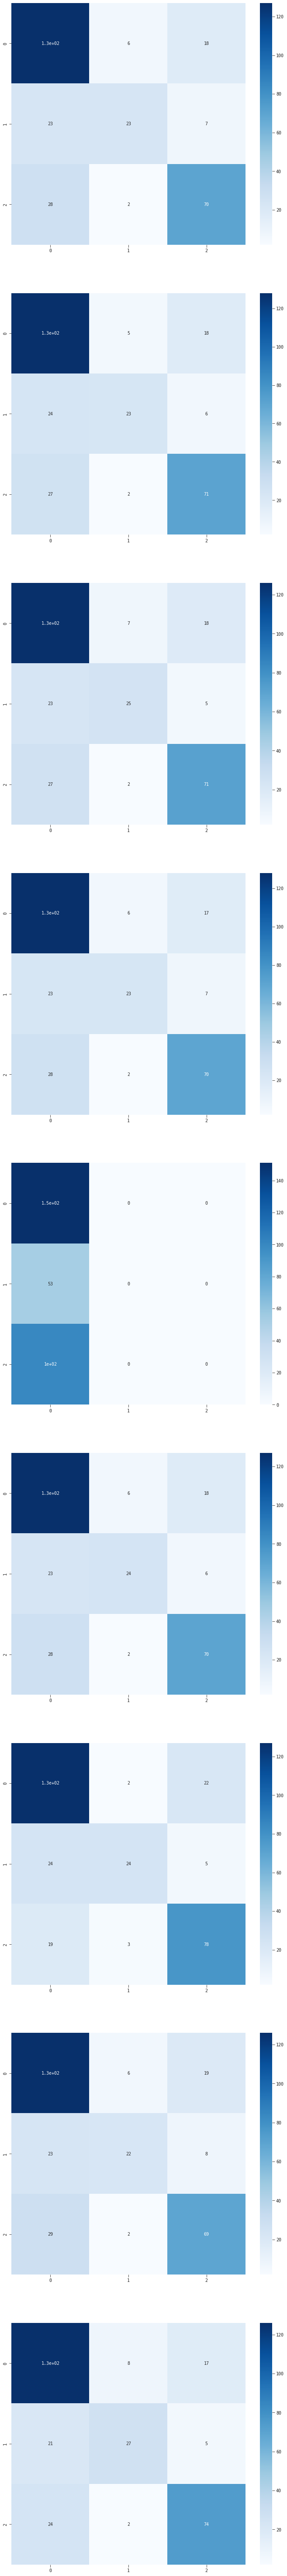

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [ ]:
plot_confusion_matrix(clfs, ['Sentence'], cm, mcc)

In [ ]:
sns.set_theme()
colors = ListedColormap(['g','b', 'c', 'y', 'm', 'r', 'k', 'orange', 'gray'])
fig, ax = plt.subplots(int(len(feature_names)), figsize=(10,20), dpi=100)
for i in range(len(feature_names)):
    acc_x = temp_acc[:,i]
    mcc_y = temp_mcc[:,i]
    scatter = ax[i].scatter(acc_x, mcc_y, c=list(range(len(models))), cmap=colors)
    if(i == int(len(feature_names)/2)):
        ax[i].legend(handles=scatter.legend_elements()[0],
                labels=models,
                loc='center left',
                bbox_to_anchor=(1, 0.5))

    ax[i].title.set_text(str("MCC and ACC for " + str(feature_names[i]) + " feature"))

    # ax[i].figure(figsize=(20, 12), dpi=100)

plt.setp(ax[:], xlabel="Accuracy")
plt.setp(ax[:], ylabel="MCC")

In [ ]:
temp_mcc

array([[0.56446358, 0.60145325, 0.60958512],
       [0.55161075, 0.62516308, 0.58270905],
       [0.54581394, 0.58997164, 0.63054184],
       [0.57194552, 0.6125147 , 0.58491503],
       [0.51154033, 0.60680393, 0.57471396],
       [0.56608673, 0.60542095, 0.58939032],
       [0.55018738, 0.60584662, 0.59459481],
       [0.62794203, 0.48304443, 0.47392733],
       [0.52505284, 0.60124606, 0.61273428]])

In [ ]:
temp_acc

array([[0.73684211, 0.75986842, 0.76315789],
       [0.72368421, 0.77302632, 0.75      ],
       [0.72368421, 0.75328947, 0.77631579],
       [0.73355263, 0.76315789, 0.75      ],
       [0.6875    , 0.76315789, 0.74342105],
       [0.73684211, 0.76315789, 0.75328947],
       [0.72368421, 0.76315789, 0.75657895],
       [0.77631579, 0.6875    , 0.68421053],
       [0.70394737, 0.75986842, 0.76644737]])

In [ ]:
ske.VotingClassifier()


# Fine-tuning model

In [ ]:
import scipy.stats as ss

train_features, test_features, train_labels, test_labels = train_test_split(
        features[0],
        data.label.values,test_size=0.2,
        random_state=42,
        stratify=data.label.values)
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

params = {
    'penalty': Categorical(['None', 'l1']),
    # 'n_iter': Integer(5, 100, prior='uniform'),
    'alpha':Real(1e-4, 1e-1, prior='uniform'),
    'eta0':Real(1e-2,1, prior='uniform')
}

mcc = make_scorer(matthews_corrcoef, greater_is_better=True)
gs = BayesSearchCV(
    sklm.Perceptron(n_jobs=-1),
    search_spaces=params,
    scoring=mcc_scorer,
    verbose=3,
    cv=5,
    n_jobs=4,
    pre_dispatch=8)

In [ ]:
gs.fit(train_features, train_labels)

In [ ]:
print(gs.best_estimator_)
print(gs.best_score_)
predict = gs.predict(test_features)
print(matthews_corrcoef(predict, test_labels))

Perceptron(alpha=0.042042605414654426, eta0=0.015800879343464348, n_jobs=-1,
           penalty='None')
0.5230436179460277
0.5157713946637411


In [ ]:
df = pd.DataFrame(gs.cv_results_)

In [ ]:
df[['rank_test_score','param_alpha', 'param_eta0', 'param_penalty', 'mean_test_score', 'std_test_score',  'mean_fit_time']].sort_values(['mean_test_score', 'std_test_score', 'mean_fit_time'], ascending=[False, True, True]).head(100)

In [ ]:
from sklearn.metrics import f1_score
print(np.mean(cross_val_score(sklm.Perceptron(alpha=0.0001, eta0=1, penalty='l1'), train_features, train_labels, cv=5, scoring=mcc_scorer, n_jobs=-1)))
print(f1_score(test_labels, sklm.Perceptron(alpha=0.0001, eta0=1, penalty='l1').fit(train_features, train_labels).predict(test_features), average='macro'))

print(np.mean(cross_val_score(sklm.Perceptron(alpha=0.0001, eta0=1, penalty='l2'), train_features, train_labels, cv=5, scoring=mcc_scorer, n_jobs=-1)))
print(f1_score(test_labels, sklm.Perceptron(alpha=0.0001, eta0=1, penalty='l2').fit(train_features, train_labels).predict(test_features), average='macro'))

print(np.mean(cross_val_score(sklm.Perceptron(alpha=0.0001, eta0=1, penalty='None'), train_features, train_labels, cv=5, scoring=mcc_scorer, n_jobs=-1)))
print(f1_score(test_labels, sklm.Perceptron(alpha=0.0001, eta0=1, penalty='None').fit(train_features, train_labels).predict(test_features), average='macro'))

0.5113295576965309
0.6972735440439402
0.4929850115982556
0.6557897143262997
0.511404238062236
0.7050554338560069


In [ ]:
print(matthews_corrcoef(test_labels, sklm.Perceptron(alpha=0.0001, eta0=0.01, penalty='l1').fit(train_features, train_labels).predict(test_features)))

0.5605095966767817


# Ensemble

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/FakeNews/Data/new/combine-preprocessed.csv")
train_features, test_features, train_labels, test_labels = train_test_split(
        features[0],
        data.label.values,test_size=0.2,
        random_state=42,
        stratify=data.label.values)

# clf1 = sklm.SGDClassifier(loss='log', eta0=0.0006, alpha=0.002, learning_rate='constant')
# clf2 = sklm.LogisticRegression(C=75, max_iter=100, n_jobs=-1,
#                    solver='liblinear')
# clf3 = sklm.SGDClassifier(n_jobs=-1,  loss='modified_huber', learning_rate='adaptive', alpha=0.374, eta0=0.0001)
# clf4 = CalibratedClassifierCV(sksvm.LinearSVC(C=3, max_iter=10000, multi_class='crammer_singer'), cv=5, n_jobs=-1)
# clfs = [('clf1',clf1), ('clf2',clf2), ('clf3', clf3),('clf4', clf4) ]

clf1 = sklm.LogisticRegression(n_jobs=-1, penalty='l2', C=0.03, solver='lbfgs')
clf2 = sksvm.SVC(C=3, kernel='poly', degree=3, max_iter=300, probability=True)

clfs = [('clf1',clf1), ('clf2',clf2)]

esclf = ske.VotingClassifier(estimators=clfs,
                            voting='soft')
ehclf = ske.VotingClassifier(estimators=clfs,
                            voting='hard')

In [ ]:
clf2.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(C=3, kernel='poly', max_iter=300, probability=True)

In [ ]:
joblib.dump(clf2, "/content/drive/MyDrive/FakeNews/Models/Sklearn/SVC_sentence.joblib")

['/content/drive/MyDrive/FakeNews/Models/Sklearn/SVC_sentence.joblib']

In [ ]:
y_pred = clf1.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[128   5  18]
 [ 14  34   5]
 [ 23   3  74]]
0.6300810268914065


In [ ]:
y_pred = clf2.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[125   8  18]
 [ 15  34   4]
 [ 22   2  76]]
0.6255071490498384


In [ ]:
y_pred = clf1.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[127   7  17]
 [ 22  27   4]
 [ 22   2  76]]
0.5951280789175656


In [ ]:
y_pred = clf2.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[128   6  17]
 [ 19  30   4]
 [ 23   3  74]]
0.6068966630138968


In [ ]:
y_pred = clf3.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[125   5  21]
 [ 19  30   4]
 [ 20   1  79]]
0.6184368819469395


In [ ]:
y_pred = clf4.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[129   6  16]
 [ 19  29   5]
 [ 24   2  74]]
0.606376303307852


In [ ]:
y_pred = clf2.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

In [ ]:
for clf in clfs:
  clf[1].fit(train_features, train_labels)

esclf.fit(train_features, train_labels)
ehclf.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


VotingClassifier(estimators=[('clf1', LogisticRegression(C=0.03, n_jobs=-1)),
                             ('clf2',
                              SVC(C=3, kernel='poly', max_iter=300,
                                  probability=True))])

In [ ]:
for clf in clfs:
  y_pred = clf[1].predict(test_features)
  print(confusion_matrix(test_labels, y_pred))
  print(matthews_corrcoef(test_labels, y_pred))


[[128   5  18]
 [ 15  33   5]
 [ 22   3  75]]
0.6298859028111593
[[125   8  18]
 [ 15  34   4]
 [ 22   2  76]]
0.6255071490498384


In [ ]:
y_pred = esclf.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))
y_pred = ehclf.predict(test_features)
print(confusion_matrix(test_labels, y_pred))
print(matthews_corrcoef(test_labels, y_pred))

[[126   7  18]
 [ 15  34   4]
 [ 23   2  75]]
0.6249523749995134
[[134   3  14]
 [ 18  31   4]
 [ 27   3  70]]
0.6235771469989165


In [ ]:
joblib.dump(ehclf, "/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_hard_sentence.joblib")
# joblib.dump(ehclf, "/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_hard_mean.joblib")

['/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_hard_sentence.joblib']

# Feyn

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
        features[0],
        data.label.values,test_size=0.2, 
        stratify=data.label.values)

In [ ]:
df = pd.DataFrame(CalibratedClassifierCV(sklm.SGDClassifier(n_jobs=-1, loss='perceptron'), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/sgdperceptron.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sklm.SGDClassifier(n_jobs=-1, loss='hinge'), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/sgdhinge.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sklm.SGDClassifier(n_jobs=-1, loss='squared_hinge'), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/sgdsquaredhinge.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sklm.Perceptron(n_jobs=-1), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/perceptron.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sklm.SGDClassifier(n_jobs=-1, loss='modified_huber'), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/sgdmodified_huber.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sksvm.LinearSVC(max_iter=10000), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/linearsvc.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sksvm.SVC(max_iter=10000), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/svc.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sklm.SGDClassifier(n_jobs=-1, loss='log'), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/sgdlog.csv", index=False)

df = pd.DataFrame(CalibratedClassifierCV(sklm.LogisticRegression(n_jobs=-1), cv=5).fit(train_features, train_labels).predict_proba(test_features))
df.to_csv("/content/drive/MyDrive/FakeNews/logisticregression.csv", index=False)

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/FakeNews/perceptron.csv")
df2 = pd.read_csv("/content/drive/MyDrive/FakeNews/sgdperceptron.csv")
df3 = pd.read_csv("/content/drive/MyDrive/FakeNews/sgdlog.csv")
df4 = pd.read_csv("/content/drive/MyDrive/FakeNews/sgdhinge.csv")
df5 = pd.read_csv("/content/drive/MyDrive/FakeNews/sgdsquaredhinge.csv")
df6 = pd.read_csv("/content/drive/MyDrive/FakeNews/svc.csv")
df7 = pd.read_csv("/content/drive/MyDrive/FakeNews/linearsvc.csv")
df8 = pd.read_csv("/content/drive/MyDrive/FakeNews/sgdmodified_huber.csv")
df9 = pd.read_csv("/content/drive/MyDrive/FakeNews/logisticregression.csv")

In [ ]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], axis=1)

In [ ]:
df.to_csv("/content/drive/MyDrive/FakeNews/qlattice.csv", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FakeNews/qlattice.csv", names=[str(x) for x in range(27)])

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000
1,0.513138,0.111754,0.375107,0.482285,0.104942,0.412773,0.503346,0.124822,0.371832,0.526050,0.107956,0.365994,0.493496,0.178049,0.328455,0.725947,0.051089,0.222964,0.535488,0.134122,0.330390,0.513264,0.106118,0.380619,0.493915,0.108518,0.397567
2,0.613655,0.127822,0.258523,0.637634,0.139246,0.223121,0.650037,0.115143,0.234821,0.639547,0.140976,0.219477,0.493496,0.178049,0.328455,0.224064,0.756817,0.019120,0.624761,0.117863,0.257376,0.626271,0.144780,0.228949,0.654075,0.164446,0.181480
3,0.144154,0.108923,0.746924,0.143307,0.122630,0.734063,0.121957,0.119984,0.758059,0.125330,0.111409,0.763261,0.493496,0.178049,0.328455,0.212912,0.047202,0.739886,0.135533,0.135183,0.729284,0.132940,0.128583,0.738477,0.132390,0.090236,0.777374
4,0.556612,0.041087,0.402302,0.520625,0.045971,0.433404,0.547111,0.045255,0.407635,0.563072,0.039474,0.397454,0.493496,0.178049,0.328455,0.734707,0.047989,0.217304,0.535669,0.050875,0.413456,0.534849,0.041204,0.423948,0.541615,0.029918,0.428467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.578798,0.069385,0.351817,0.580131,0.084558,0.335310,0.541663,0.082229,0.376107,0.589071,0.088938,0.321991,0.493496,0.178049,0.328455,0.203945,0.046780,0.749275,0.526062,0.107963,0.365976,0.595738,0.094862,0.309400,0.547283,0.064797,0.387920
301,0.468588,0.404916,0.126497,0.463776,0.425239,0.110986,0.478151,0.392417,0.129432,0.525651,0.365589,0.108759,0.493496,0.178049,0.328455,0.727269,0.253397,0.019334,0.478236,0.373758,0.148006,0.482575,0.414369,0.103056,0.552504,0.362719,0.084778
302,0.715426,0.086461,0.198114,0.740825,0.092012,0.167163,0.716184,0.100857,0.182959,0.708331,0.106008,0.185661,0.493496,0.178049,0.328455,0.756379,0.052283,0.191338,0.727859,0.105561,0.166579,0.749068,0.086098,0.164834,0.707754,0.121709,0.170537
303,0.758619,0.110911,0.130470,0.762030,0.104166,0.133804,0.760156,0.109787,0.130057,0.772121,0.103279,0.124600,0.493496,0.178049,0.328455,0.789498,0.052523,0.157979,0.736163,0.108978,0.154859,0.765042,0.107236,0.127722,0.806050,0.086923,0.107027


In [ ]:
input, target = df.iloc[:, :-1].copy(), df.iloc[:, -1].copy()
input.head()

,0,1,2,0.1,1.1,2.1,0.2,1.2,2.2,0.3,1.3,2.3,0.4,1.4,2.4,0.5,1.5,2.5,0.6,1.6,2.6,0.7,1.7,2.7,0.8,1.8,2.8
0,0.710312,0.145001,0.144687,0.710894,0.137163,0.151943,0.738137,0.127783,0.134080,0.707802,0.150653,0.141545,0.493496,0.178049,0.328455,0.870492,0.113274,0.016234,0.701462,0.138018,0.160520,0.721571,0.129144,0.149285,0.992060,7.869233e-03,0.000071
1,0.100394,0.056966,0.842640,0.091477,0.068967,0.839556,0.086742,0.052309,0.860948,0.078100,0.055828,0.866073,0.493496,0.178049,0.328455,0.147518,0.035767,0.816715,0.131642,0.045602,0.822757,0.084399,0.059690,0.855911,0.000017,2.258934e-05,0.999960
2,0.317791,0.065203,0.617005,0.311354,0.060672,0.627974,0.302993,0.056181,0.640825,0.358889,0.043317,0.597794,0.493496,0.178049,0.328455,0.203486,0.025703,0.770810,0.350684,0.051479,0.597837,0.317391,0.052788,0.629820,0.076909,2.370606e-04,0.922854
3,0.940485,0.010232,0.049282,0.942090,0.009715,0.048195,0.948484,0.009088,0.042428,0.944516,0.008347,0.047137,0.493496,0.178049,0.328455,0.959888,0.007371,0.032741,0.919360,0.009479,0.071161,0.939874,0.007063,0.053063,0.999978,2.450309e-08,0.000022
4,0.710154,0.058567,0.231279,0.722872,0.043244,0.233883,0.695925,0.056027,0.248047,0.720227,0.046069,0.233704,0.493496,0.178049,0.328455,0.588284,0.102363,0.309352,0.701877,0.056721,0.241402,0.733028,0.055998,0.210973,0.834802,7.418775e-03,0.157779


In [ ]:
ql = feyn.connect_qlattice()

A new Community QLattice has been allocated for you. This temporary QLattice is available for personal/non-commercial use. By using this Community QLattice you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [ ]:
ql.reset(random_seed=42)

In [ ]:
# Set random seed for reproducibility
random_seed = 42

# Define the target variable
label = "label"

# Split
# train_input, test_input, train_output, test_output = train_test_split(input, target, test_size=0.2, stratify=target, random_state=random_seed)
train, test = train_test_split(df, test_size=0.2, stratify=target, random_state=random_seed)

In [ ]:
train[train.iloc[:, -1] == 0]

,0,1,2,0.1,1.1,2.1,0.2,1.2,2.2,0.3,1.3,2.3,0.4,1.4,2.4,0.5,1.5,2.5,0.6,1.6,2.6,0.7,1.7,2.7,0.8,1.8,2.8,label
888,0.720867,0.170719,0.108413,0.709937,0.186468,0.103595,0.723638,0.165362,0.111000,0.692318,0.202142,0.105540,0.493496,0.178049,0.328455,0.439602,0.517932,0.042466,0.705508,0.158088,0.136404,0.695688,0.193931,0.110380,0.283243,0.706186,0.010572,0
335,0.744814,0.083053,0.172133,0.776819,0.063522,0.159658,0.765550,0.082662,0.151787,0.810070,0.057257,0.132673,0.493496,0.178049,0.328455,0.862304,0.051304,0.086392,0.720930,0.095462,0.183608,0.778493,0.064088,0.157419,0.994291,0.003548,0.002161,0
1055,0.870218,0.075339,0.054443,0.842992,0.085900,0.071108,0.896324,0.063601,0.040076,0.900455,0.059842,0.039703,0.493496,0.178049,0.328455,0.746842,0.056642,0.196516,0.846179,0.073707,0.080114,0.889295,0.062850,0.047855,0.999611,0.000111,0.000277,0
241,0.642324,0.041105,0.316571,0.743182,0.032629,0.224189,0.692575,0.035868,0.271557,0.675562,0.040933,0.283506,0.493496,0.178049,0.328455,0.738176,0.055413,0.206411,0.638124,0.045768,0.316109,0.690925,0.052113,0.256962,0.151916,0.000314,0.847770,0
865,0.548829,0.133825,0.317346,0.545709,0.143563,0.310728,0.549936,0.111761,0.338304,0.533424,0.124872,0.341704,0.493496,0.178049,0.328455,0.157096,0.034935,0.807969,0.586632,0.114367,0.299002,0.579325,0.114818,0.305857,0.148157,0.018622,0.833221,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,0.789872,0.068386,0.141742,0.768154,0.080657,0.151189,0.811781,0.068912,0.119306,0.800061,0.068973,0.130966,0.493496,0.178049,0.328455,0.898252,0.041052,0.060696,0.783999,0.061213,0.154788,0.826826,0.067823,0.105352,0.996680,0.000479,0.002841,0
430,0.554703,0.129750,0.315548,0.551416,0.097805,0.350779,0.553166,0.120776,0.326058,0.537632,0.128685,0.333682,0.493496,0.178049,0.328455,0.401525,0.094912,0.503563,0.551310,0.137332,0.311358,0.544843,0.120214,0.334943,0.004212,0.003338,0.992450,0
378,0.717230,0.096867,0.185903,0.714484,0.117869,0.167648,0.728297,0.098694,0.173010,0.728265,0.087740,0.183994,0.493496,0.178049,0.328455,0.597800,0.081917,0.320283,0.676320,0.126781,0.196899,0.702166,0.098946,0.198888,0.904256,0.003515,0.092229,0
243,0.606003,0.029776,0.364221,0.602977,0.023927,0.373096,0.622667,0.028358,0.348975,0.602223,0.028588,0.369189,0.493496,0.178049,0.328455,0.522484,0.018082,0.459434,0.635033,0.032129,0.332838,0.604781,0.023753,0.371466,0.131381,0.000054,0.868564,0


In [ ]:
# train_0 = pd.merge(train_input, train_cat.iloc[:, 0], left_index=True, right_index=True)
# train_0

In [ ]:
# models = ql.auto_run(train_0, output_name='label_0', criterion='classification')

In [ ]:
import feyn
import pandas as pd
from sklearn.utils import compute_sample_weight


class QLatticeModel:
    def __init__(self, classes, max_iter=10, early_stop=0.001):
        self.models = []
        self.max_iter = max_iter
        self.classes = classes
        self.early_stop = early_stop
        self._qls = []
        self._models = []
        for i in range(self.classes):
            self._qls.append(feyn.connect_qlattice())
            self._models.append([])

    def fit(self, x: np.ndarray, y: np.ndarray):
        y_one_hot = np.zeros((y.size, y.max() + 1))
        y_one_hot[np.arange(y.size), y] = 1
        x_columns = [f"x_{i}" for i in range(x.shape[1])]
        y_columns = [f"y_{i}" for i in range(self.classes)]
        train = np.concatenate((x, y_one_hot), axis=1)
        train = pd.DataFrame(train, columns=[*x_columns, *y_columns])
        print(train.head())

        for i, ql in enumerate(self._qls):
            losses = []
            for epoch in range(self.max_iter):
                ql = self._qls[i]
                # sample_weights = sample_weights_list[i]
                # Sample models from the QLattice, and add them to the list
                self._models[i] += ql.sample_models(input_names=x_columns,
                                                    output_name=f'y_{i}',
                                                    kind='regression')

                # Fit the list of models. Returns a list of models sorted by loss or criterion.
                self._models[i] = feyn.fit_models(self._models[i],
                                                  data=train,
                                                  loss_function='absolute_error',
                                                  threads=10)

                # Remove redundant and poorly performing models from the list
                self._models[i] = feyn.prune_models(self._models[i])

                # Find the 10 best and sufficiently diverse models
                self._models[i] = feyn.get_diverse_models(self._models[i])

                # Display the best model in the current epoch
                # feyn.show_model(self._models[i][0], label=f"Epoch: {epoch}", update_display=True)

                # Update QLattice with the 10 best and diverse models
                ql.update(self._models[i])
                
                losses.append(self._models[i][0].loss_value)
                
                print("Epoch {}. Class {}. Loss: {}".format(epoch, i, losses[-1]))
                                                                     
                if epoch > 3:
                    if losses[-2] / losses[-1] < (1 + self.early_stop) and losses[-3] / losses[-2] < (1 + self.early_stop):
                        print(f"Stopping training for class {i}")
                        break
    
    def predict(self, x):                                                                                                                   
        x_columns = [f"x_{i}" for i in range(x.shape[1])]                
        test = pd.DataFrame(x.values, columns=x_columns)    
        predictions = []    
        for i, ql in enumerate(self._qls):
            model = self._models[i][0]
            # print(model.predict(test))
            predictions.append(model.predict(test))
        return np.stack(predictions, axis=1)

In [ ]:
model = QLatticeModel(classes=3, max_iter=30, early_stop=0.0001)
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

In [ ]:
y_pred = model.predict(test.iloc[:, :-1])

In [ ]:
y_pred = test.iloc[:, :-1].values
y_pred = np.reshape(y_pred, (-1, 9, 3))
y_pred = np.argmax(y_pred.sum(axis=1), axis=1)
print(y_pred)

[2 0 0 0 2 2 0 0 0 2 0 0 2 2 0 2 2 2 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 1 0 0 0
 0 0 2 0 0 2 0 2 0 0 0 0 0 1 0 2 2 0 0 0 2 2 0 2 2 0 2 1 2 0 2 2 0 0 2 2 0
 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 2 0 1 2 0 2 0 0 2 0 0 0 0 2 0 2 1 2 0 0 0
 0 2 1 2 2 0 0 2 0 0 2 2 1 0 2 0 0 0 0 0 2 0 2 2 0 0 0 0 2 0 0 2 0 0 0 1 2
 2 0 0 0 1 0 0 0 0 2 0 0 2 0 0 2 0 2 2 2 0 0 0 0 2 0 0 0 1 0 0 0 0 2 1 0 2
 0 2 1 2 1 0 2 2 0 2 2 2 1 0 2 0 0 0 2 0 0 0 0 0 0 2 1 0 0 0 2 1 2 0 0 0 0
 1 2 2 0 2 0 0 1 1 0 0 2 0 0 0 0 0 0 2 0 0]


In [ ]:
test.iloc[:, :-1]

,0,1,2,0.1,1.1,2.1,0.2,1.2,2.2,0.3,1.3,2.3,0.4,1.4,2.4,0.5,1.5,2.5,0.6,1.6,2.6,0.7,1.7,2.7,0.8,1.8,2.8
595,0.464061,0.136987,0.398952,0.508009,0.141519,0.350472,0.474967,0.139787,0.385246,0.487118,0.129844,0.383038,0.493496,0.178049,0.328455,0.113740,0.016584,0.869676,0.546659,0.124499,0.328842,0.492688,0.154242,0.353070,0.000527,0.000084,9.993891e-01
1044,0.714260,0.129629,0.156110,0.721706,0.136708,0.141586,0.733473,0.123173,0.143355,0.729598,0.105971,0.164431,0.493496,0.178049,0.328455,0.776461,0.051279,0.172260,0.726433,0.116668,0.156898,0.725410,0.114886,0.159704,0.982975,0.011230,5.794700e-03
728,0.556499,0.269864,0.173638,0.537082,0.309645,0.153273,0.553901,0.294279,0.151821,0.515127,0.305814,0.179058,0.493496,0.178049,0.328455,0.147626,0.793404,0.058970,0.615360,0.249625,0.135015,0.557898,0.272208,0.169894,0.008730,0.972875,1.839450e-02
132,0.753715,0.212767,0.033518,0.750935,0.216135,0.032930,0.751423,0.220466,0.028111,0.741788,0.226254,0.031958,0.493496,0.178049,0.328455,0.625293,0.362781,0.011926,0.730668,0.225972,0.043359,0.733542,0.235959,0.030499,0.286699,0.713292,9.132130e-06
270,0.144070,0.221447,0.634483,0.153758,0.220693,0.625549,0.149902,0.191056,0.659041,0.176688,0.173064,0.650249,0.493496,0.178049,0.328455,0.051604,0.264524,0.683872,0.168174,0.173222,0.658604,0.164222,0.201834,0.633944,0.003316,0.083147,9.135368e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,0.660863,0.086107,0.253030,0.636495,0.083423,0.280083,0.699540,0.085942,0.214518,0.710919,0.075708,0.213373,0.493496,0.178049,0.328455,0.911726,0.048546,0.039728,0.700631,0.068490,0.230878,0.661636,0.067555,0.270808,0.994712,0.003531,1.757337e-03
547,0.885067,0.091984,0.022949,0.890044,0.091748,0.018208,0.880907,0.101886,0.017207,0.892321,0.090618,0.017061,0.493496,0.178049,0.328455,0.949907,0.038724,0.011369,0.851177,0.121240,0.027583,0.886743,0.094029,0.019227,0.999416,0.000584,4.564430e-07
745,0.323388,0.091848,0.584764,0.321648,0.079720,0.598632,0.341618,0.079095,0.579287,0.321968,0.073732,0.604301,0.493496,0.178049,0.328455,0.351719,0.038429,0.609852,0.343463,0.109867,0.546670,0.332436,0.080964,0.586600,0.283643,0.007398,7.089590e-01
1030,0.693779,0.011599,0.294622,0.686651,0.010856,0.302493,0.694372,0.012359,0.293269,0.693814,0.012104,0.294082,0.493496,0.178049,0.328455,0.217020,0.036404,0.746577,0.655756,0.009925,0.334318,0.665763,0.013610,0.320627,0.055674,0.000006,9.443199e-01


In [ ]:
y_pred

In [ ]:
print(confusion_matrix(test.iloc[:, -1], y_pred))
print(matthews_corrcoef(test_temp, y_temp))

In [ ]:
y_temp = (1 - y_pred).copy()
y_temp = [0 if y_sample[0] > 0.5 else 1 for y_sample in y_temp]
test_temp = test.iloc[:, -1].values
test_temp = [0 if sample == 0 else 1 for sample in test_temp]
print(confusion_matrix(test_temp, y_temp))
print(matthews_corrcoef(test_temp, y_temp))

In [ ]:
y_temp = [1 if y_sample[1] > 0.2 else 0 for y_sample in y_pred]
test_temp = test.iloc[:, -1].values
test_temp = [1 if sample == 1 else 0 for sample in test_temp]
print(confusion_matrix(test_temp, y_temp))
print(matthews_corrcoef(test_temp, y_temp))

[[200   0]
 [ 43   0]]
0.0


In [ ]:
y_temp = [2 if y_sample[2] > 0.5 else 1 for y_sample in y_pred]
test_temp = test.iloc[:, -1].values
test_temp = [2 if sample == 2 else 1 for sample in test_temp]
print(confusion_matrix(test_temp, y_temp))
print(matthews_corrcoef(test_temp, y_temp))

[[148  15]
 [ 70  10]]
0.05100719116914077


In [ ]:
class_id = 0
feyn.show_model(model._models[class_id][0])

0.24160107975673467


In [ ]:
print(confusion_matrix(test_, y_temp))
print(matthews_corrcoef(test_temp, y_temp))

In [ ]:
type(test.iloc[:, :-1])

pandas.core.frame.DataFrame

In [ ]:
train.iloc[:, :-1:3]

In [ ]:
test.iloc[:, :-1]

In [ ]:
y_pred

In [ ]:
pred = np.argmax(y_pred, axis = 1)

In [ ]:
pred

In [ ]:
test.iloc[:, -1].values

In [ ]:
confusion_matrix(test.iloc[:, -1].values, pred)

In [ ]:
matthews_corrcoef(test.iloc[:, -1].values, pred)

1.0

In [ ]:
y_pred = model.predict(train.iloc[:, :-1])

In [ ]:
pred = np.argmax(y_pred, axis = 1)

In [ ]:
confusion_matrix(train.iloc[:, -1].values, pred)

array([[482,   0,   0],
       [  0, 171,   0],
       [  0,   0, 319]])

In [ ]:
matthews_corrcoef(train.iloc[:, -1].values, pred)

1.0

# Test run submission

In [ ]:
index = pd.read_csv("/content/drive/MyDrive/FakeNews/Test/test-task-1.csv", names = ['index', 'text'])

In [ ]:
model1 = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_soft_mean.joblib")
model2 = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_hard_mean.joblib")
model3 = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_soft_sentence.joblib")
model4 = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/ensemble_hard_sentence.joblib")
model5 = joblib.load("/content/drive/MyDrive/FakeNews/Models/Sklearn/SVC_sentence.joblib")

In [ ]:
models = [model1, model2, model3, model4]

In [ ]:
prediction = []
prediction.append(model1.predict(mean1))
prediction.append(model2.predict(mean1))
prediction.append(model3.predict(sentence1))
prediction.append(model4.predict(sentence1))

In [ ]:
prediction

In [ ]:
result = []
for i in prediction:
  a = np.stack((index, i), axis=-1)
  dataset = pd.DataFrame(a, columns=['index', 'label'])
  result.append(dataset)

In [ ]:
result[3].to_csv("/content/drive/MyDrive/FakeNews/Test/result4.csv", index=False)

In [ ]:
prediction = model5.predict(sentence1)

In [ ]:
prediction

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       2, 2, 0, 1, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0,
       2, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0,
       2, 2, 0, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1,
       0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 1, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1,
       2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0])

In [ ]:
a = np.stack((np.array(index), prediction), axis=-1)
dataset = pd.DataFrame(a, columns=['index', 'label'])

In [ ]:
dataset

,index,label
0,2084,0
1,2085,0
2,2086,2
3,2087,0
4,2088,0
...,...,...
261,2345,0
262,2346,0
263,2347,0
264,2348,2


In [ ]:
dataset.to_csv("/content/drive/MyDrive/FakeNews/Test/result5.csv", index=False)